# Shapelet Discovery

In the time series context, Shapelets are prototypical time series “snippets” that can be used to classify unlabeled time series that contain an occurrence of the shapelet. [1]  New Approaches suggest that the Matrix Profile can be used to efficiently identify shapelets of a particular class.

In this tutorial, we are going to implement shapelets with STUMPY using the GunPoint dataset, which you can download from [here](http://alumni.cs.ucr.edu/~lexiangy/Shapelet/gun.zip).

The **GunPoint dataset** is a timeseries representatiton of two actors making a motion with their hand. We have two classes in the dataset: Gun and Point. In the Gun class, the actors draw a gun from a hip-mounted holster and point it at a target for approximately one second, then return the gun to the holster, and their hands to their sides. In the Point class,the actors have their gun by their sides. They point with their index fingers to a target for approximately one second, and then return their hands to their sides. For both classes, the centroid of the actors' right hand was tracked to represent its motion.

## Load Libraries

In [41]:
%matplotlib inline

import stumpy
import pandas as pd
import numpy as np
from zipfile import ZipFile
from io import BytesIO
import os
from urllib.request import urlopen
import matplotlib.pyplot as plt

np.random.seed(1337)  # Random seed for reproducibility

In [42]:
# useful plot function automatically resize and create the plots
def change_plot_size(width, height, plt):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size


change_plot_size(20, 6, plt)

## Load Data

In [43]:
# load train data and put it in a dataframe
fzip = urlopen("http://alumni.cs.ucr.edu/~lexiangy/Shapelet/gun.zip")
train = ZipFile(BytesIO(fzip.read())).extract("gun_train")
train_df = pd.read_csv(train, sep="\\s+", header=None)
os.remove(train)

In [44]:
# load test data and put it in a dataframe
fzip = urlopen("http://alumni.cs.ucr.edu/~lexiangy/Shapelet/gun.zip")
test = ZipFile(BytesIO(fzip.read())).extract("gun_test")
test_df = pd.read_csv(test, sep="\\s+", header=None)
os.remove(test)

In [45]:
# shape of our dataframes
train_df.shape, test_df.shape

((50, 151), (150, 151))

In [46]:
train_df.head()

0         1         2         3         4         5         6         7    \
0  0.0 -0.778353 -0.778279 -0.777151 -0.777684 -0.775900 -0.772421 -0.765464   
1  1.0 -0.647885 -0.641992 -0.638186 -0.638259 -0.638345 -0.638697 -0.643049   
2  0.0 -0.750060 -0.748103 -0.746164 -0.745926 -0.743767 -0.743805 -0.745213   
3  1.0 -0.644427 -0.645401 -0.647055 -0.647492 -0.646910 -0.643884 -0.639731   
4  0.0 -1.177206 -1.175839 -1.173185 -1.170890 -1.169488 -1.166309 -1.165919   

        8         9    ...       141       142       143       144       145  \
0 -0.762275 -0.763752  ... -0.722055 -0.718712 -0.713534 -0.710021 -0.704126   
1 -0.643768 -0.645050  ... -0.639264 -0.639716 -0.639735 -0.640184 -0.639235   
2 -0.745082 -0.745727  ... -0.721667 -0.724661 -0.729229 -0.728940 -0.727834   
3 -0.638094 -0.635297  ... -0.641140 -0.641426 -0.639267 -0.637797 -0.637680   
4 -1.167642 -1.166901  ... -1.225565 -1.295701 -1.327421 -1.327071 -1.300439   

        146       147       148       149       150  
0 -0.703263 -0.703393 -0.704196 -0.707605 -0.707120  
1 -0.639395 -0.640231 -0.640429 -0.638666 -0.638657  
2 -0.728244 -0.726453 -0.725517 -0.725191 -0.724679  
3 -0.635260 -0.635490 -0.634934 -0.634497 -0.631596  
4 -1.271138 -1.267283 -1.265006 -1.270722 -1.262134  

[5 rows x 151 columns]

As we can see, the first column represent the target class. with `0.0` being the Gun class and `1.0` being the Point class. 

In [47]:
# number of examples for class in train and test
train_df[0].value_counts(), test_df[0].value_counts()

(1.0    26
 0.0    24
 Name: 0, dtype: int64,
 0.0    76
 1.0    74
 Name: 0, dtype: int64)

Let's look at our data!
The first Two examples from our dataset are plotted below

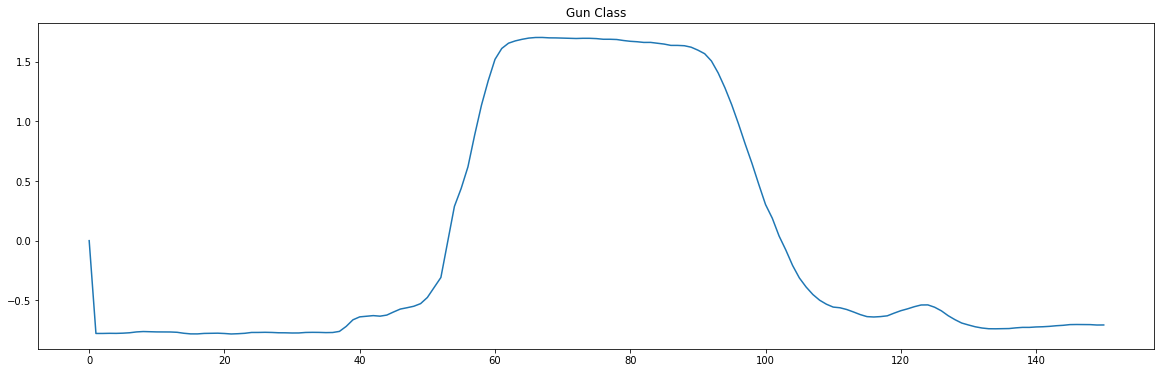

In [48]:
gun_sample = train_df.iloc[0, :]
plt.title("Gun Class")
plt.plot(gun_sample)

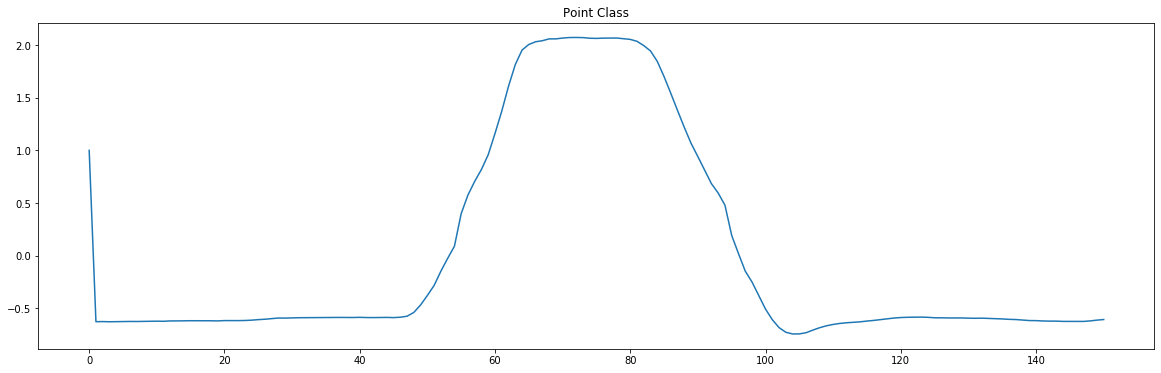

In [49]:
nogun_sample = test_df.iloc[1, :]
plt.title("Point Class")
plt.plot(nogun_sample)

## Construct Time Serieses

Now that we have our dataset, we can construct a time series $T_{A}$ by concatenating all the instances in the Train dataset of the Gun class, and construct a time series $T_{B}$ by concatenating all the instances of the Point class. Note that we are adding an *NaN* value at the end of each instance in order to reduce artificially created noise and non-existent patterns in our timeseries.

Shapelet based classification requires a method of finding and assessing shapelets, then an algorithm for using the selected shapelets for classification. According to a recent paper [2], the Matrix Profile can help us quickly identify good shapelet candidates, for free. 

In [50]:
# Split train and test into features and target
X_train, y_train = train_df.iloc[:, 1:], train_df.iloc[:, 0]
X_test, y_test = test_df.iloc[:, 1:], test_df.iloc[:, 0]

In [51]:
# Split train into features and target (Gun and Point)
X_train_gun = train_df[train_df.iloc[:, 0] == 0.0].iloc[:, 1:]
X_train_point = train_df[train_df.iloc[:, 0] == 1.0].iloc[:, 1:]
y_train_gun = train_df[train_df.iloc[:, 0] == 0.0].iloc[:, 0]
y_train_point = train_df[train_df.iloc[:, 0] == 1.0].iloc[:, 0]

In [52]:
X_train_gun.shape, X_train_point.shape

((24, 150), (26, 150))

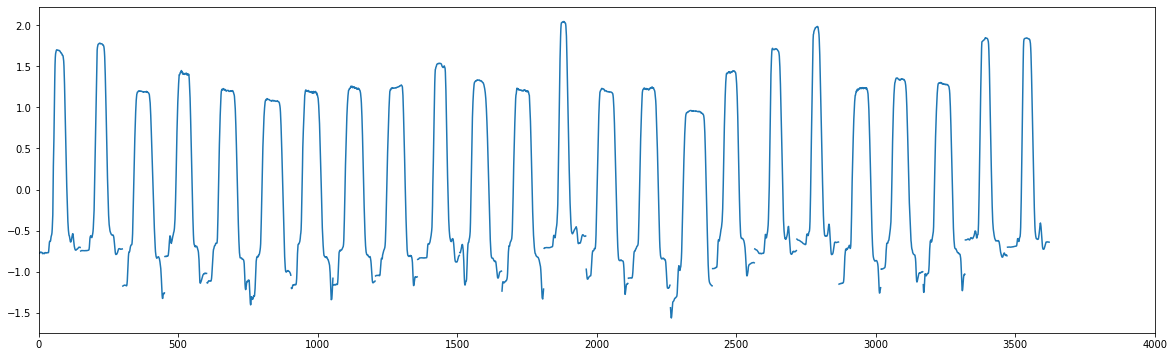

In [53]:
# construct and plot Gun timeseries (T_A)
X_train_gun = X_train_gun.assign(NaN=np.nan)  # add NaN values
T_A = X_train_gun.stack(dropna=False).to_frame().reset_index(drop=True)
plt.xlim(0, 4000)
plt.plot(T_A)

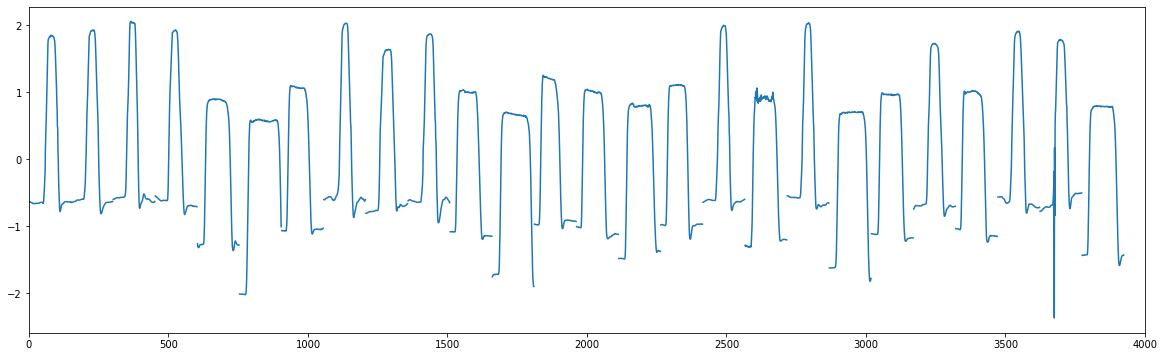

In [54]:
# construct and plot Point timeseries (T_B)
X_train_point = X_train_point.assign(NaN=np.nan)
T_B = X_train_point.stack(dropna=False).to_frame().reset_index(drop=True)
plt.xlim(0, 4000)
plt.plot(T_B)

## Matrix Profiles

We then compute two matrix profiles, $P_{BB}$ and $P_{BA}$. In the first matrix profiles, distances are calculated within the same timeseries ($T_{B}$), in the second case we are comparing subsequences from $T_{A}$ with those of $T_{B}$. For simplicity, we use a subsequence length of 38, which is the length of the best shapelet reported for this dataset by Ye and Keogh (2009) [2] 

In [55]:
m = 38
P_BB = stumpy.stump(T_B.iloc[:, 0], m).astype(np.float64)
P_BA = stumpy.stump(T_A.iloc[:, 0], m, T_B.iloc[:, 0], ignore_trivial=False).astype(
    np.float64
)

Since we have some `np.nan` values in the our timeseries, the outputs of the Matrix profiles contain several `np.inf`values. We will manually correct this by changing them to `np.nan`

In [56]:
P_BB[P_BB == np.inf] = np.nan
P_BA[P_BA == np.inf] = np.nan

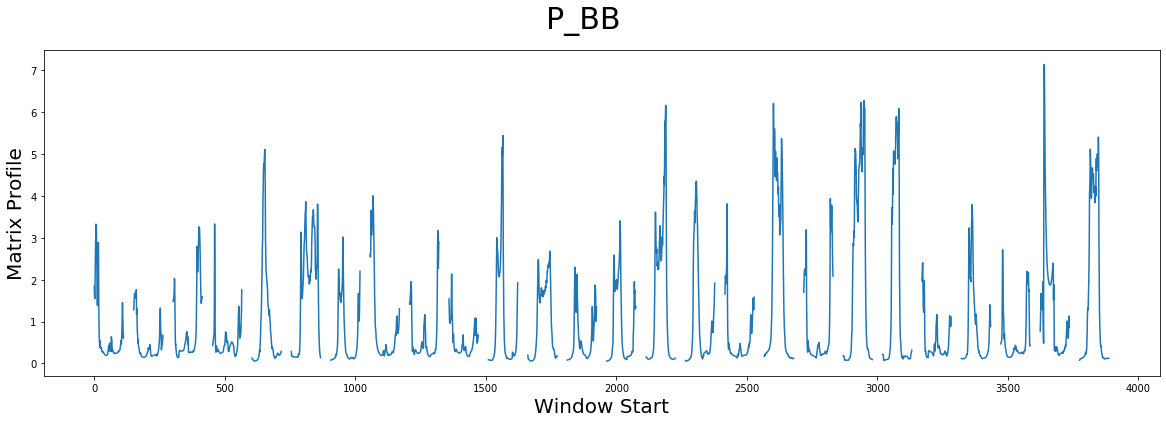

In [57]:
# Plot P_BB
plt.suptitle("P_BB", fontsize="30")
plt.xlabel("Window Start", fontsize="20")
plt.ylabel("Matrix Profile", fontsize="20")
plt.plot(P_BB[:, 0])

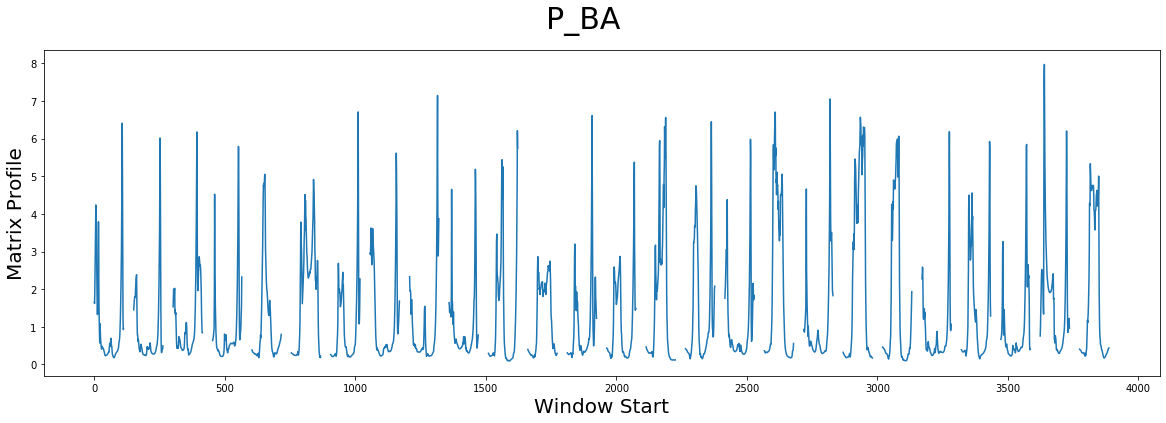

In [58]:
# plot P_BA
plt.suptitle("P_BA", fontsize="30")
plt.xlabel("Window Start", fontsize="20")
plt.ylabel("Matrix Profile", fontsize="20")
plt.plot(P_BA[:, 0])

We call $P$ The difference between $P_{BA}$ and $P_{BB}$. Intuitively, $P_{BB}$ will be smaller than $P_{BA}$ because we would expect subsequences within the same class to be more similar than those of different classes. 

The peak values in $P$ are indicators of good shapelet candidates, because they suggest patterns that are well conserved in their own class but are very different from their closest match in the other class.

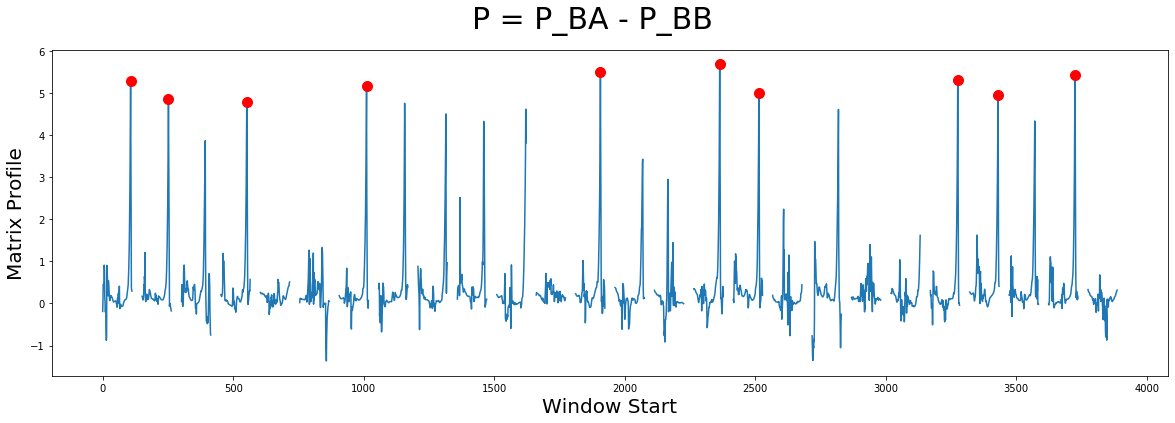

In [59]:
# subtract P_BB from P_BA
P = P_BA[:, 0] - P_BB[:, 0]
idx = np.argpartition(np.nan_to_num(P), -10)[
    -10:
]  # get the indexes of 10 peak values in P
plt.suptitle("P = P_BA - P_BB", fontsize="30")
plt.xlabel("Window Start", fontsize="20")
plt.ylabel("Matrix Profile", fontsize="20")
plt.plot(P)
plt.plot(
    idx, P[idx], color="red", marker="o", linewidth=0, markersize=10
)  # plot the indexes over P

## Shapelets and Classifier

Let's take a look at one of the shapelets that were identified through the matrix profile method.

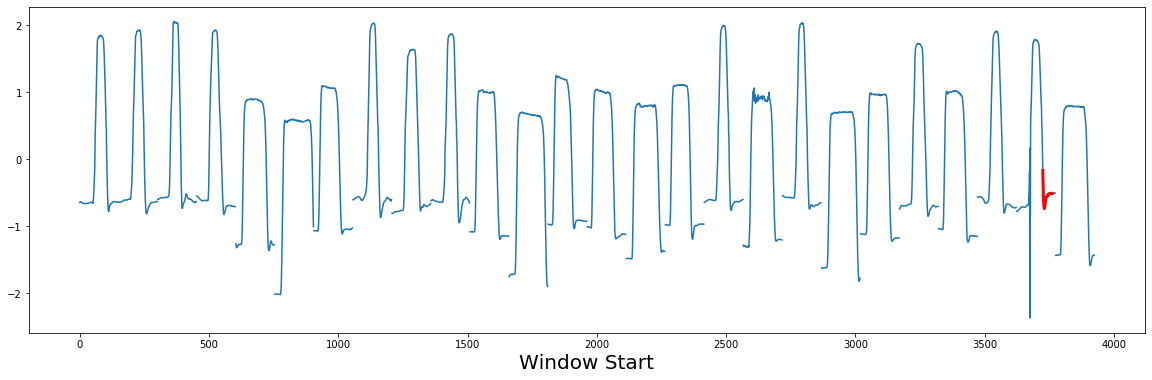

In [60]:
# Plot Shapelet
max_idx = np.random.choice(idx)
# max_idx = np.argwhere(P == np.nanmax(P)).flatten()[0]

plt.xlabel("Window Start", fontsize="20")
plt.plot(T_B.iloc[:, 0])
plt.plot(
    list(range(max_idx, (max_idx + m))),
    T_B.iloc[max_idx : (max_idx + m), 0],
    "r",
    linewidth=3.0,
)

Now that we have the indexes our Peak values we can use them to extract the values of shapelets candidates from the $T_{B}$ time series.

In [61]:
shapelets = []
for i in idx:
    shapelet = list(T_B.iloc[i : (i + m), 0])
    shapelets.append(shapelet)

Now, for our classification task, each shapelets needs to be evalued in terms of its predicitive power. Thus, we first calculate the distance profile (pairwise Euclidean distance) between a shapelet and every subsequence of a time-series. Then, the smallest value is kept to understand if a close match of the shapelet in the timeseries has been found. The `stumpy.core.mass` function does exactly so.

In [62]:
# Calculate distances from timeseries to extracted shapelets
def difference_matrix(X, shapelets):
    """Compute the distance beteen X, and the shapelets. Return a (len(X), len(shapelet)) distance matrix"""
    D = np.zeros((len(X), len(shapelets)))
    for s, shapelet in enumerate(shapelets):
        for i in range(len(X)):
            dist = stumpy.core.mass(shapelet, X.iloc[i, :])
            min_dist = dist.min()
            D[i, s] = min_dist
    return D

In [63]:
D_train_point = difference_matrix(X_train, shapelets)
D_test_point = difference_matrix(X_test, shapelets)

In [64]:
from sklearn import tree
from sklearn import metrics

for i in range(len(shapelets)):
    clf = tree.DecisionTreeClassifier()
    clf.fit(D_train_point[:, i].reshape(-1, 1), y_train)
    y_pred = clf.predict(D_test_point[:, i].reshape(-1, 1))
    print(f"Accuracy for shapelet {i} = {round(metrics.accuracy_score(y_test, y_pred), 3)}")

Accuracy for shapelet 0 = 0.867
Accuracy for shapelet 1 = 0.833
Accuracy for shapelet 2 = 0.807
Accuracy for shapelet 3 = 0.833
Accuracy for shapelet 4 = 0.933
Accuracy for shapelet 5 = 0.873
Accuracy for shapelet 6 = 0.873
Accuracy for shapelet 7 = 0.833
Accuracy for shapelet 8 = 0.86
Accuracy for shapelet 9 = 0.913


Great!! Classification with the best shapelet returns 93.3% in terms of accuracy, this result exactly reproduces those of Zhu, Y. et al. (2020) [2]

## Extra: Shapelets for second class

As a little extra, we are also going to extract the shapelets from the $T_{A}$ time series to see if they add predictive power to our model. The procedure is identical to the one that I have explained above, so I am not gonna go into too much detail here.

In [65]:
m = 38
P_AA = stumpy.stump(T_A.iloc[:, 0], m).astype(np.float64)  # TODO: rename column (?)
P_AB = stumpy.stump(T_B.iloc[:, 0], m, T_A.iloc[:, 0], ignore_trivial=False).astype(
    np.float64
)
P_AA[P_AA == np.inf] = np.nan
P_AB[P_AB == np.inf] = np.nan

In [66]:
P = P_AB[:, 0] - P_AA[:, 0]
idx = np.argpartition(np.nan_to_num(P), -10)[
    -10:
]  # get the indexes of 10 peak values in P

In [67]:
shapelets = []
for i in idx:
    shapelet = list(T_A.iloc[i : (i + m), 0])
    shapelets.append(shapelet)

In [68]:
D_train_gun = difference_matrix(X_train, shapelets)
D_test_gun = difference_matrix(X_test, shapelets)

In [69]:
from sklearn import tree
from sklearn import metrics

for i in range(len(shapelets)):
    X_train = np.concatenate(
        (D_train_gun[:, i].reshape(-1, 1), D_train_point[:, i].reshape(-1, 1)), axis=1
    )
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    X_test = np.concatenate(
        (D_test_gun[:, i].reshape(-1, 1), D_test_point[:, i].reshape(-1, 1)), axis=1
    )
    y_pred = clf.predict(X_test)
    print(f"Accuracy for shapelets {i} = {round(metrics.accuracy_score(y_test, y_pred), 3)}")

Accuracy for shapelets 0 = 0.913
Accuracy for shapelets 1 = 0.853
Accuracy for shapelets 2 = 0.813
Accuracy for shapelets 3 = 0.953
Accuracy for shapelets 4 = 0.933
Accuracy for shapelets 5 = 0.867
Accuracy for shapelets 6 = 0.887
Accuracy for shapelets 7 = 0.867
Accuracy for shapelets 8 = 0.867
Accuracy for shapelets 9 = 0.913


We can see that if we include both distances from `Gun` class shapelets and `Point` class shapelets, the classifier reaches 95.3% accuracy! Apparently, adding the distances from the second class as well providest the model with additional useful information. This is a great result as it improves the result of Zhu, Y. et al. (2020) [2] by roughly 2%. Again, it is impressive to note that all this information can be extracted for free from the Matrix profile.

## References

[1] Rakthanmanon, T. and Keogh, E., 2013, May. Fast shapelets: A scalable algorithm for discovering time series shapelets. In *proceedings of the 2013 SIAM International Conference on Data Mining (pp. 668-676)*. Society for Industrial and Applied Mathematics.

[2] Zhu, Y. et al. (2020) “The Swiss army knife of time series data mining: ten useful things you can do with the matrix profile and ten lines of code,” Data Mining and Knowledge Discovery. Springer Science and Business Media LLC, 34(4), pp. 949–979. doi: 10.1007/s10618-019-00668-6.

[3] Ye, L. and Keogh, E., 2009, June. Time series shapelets: a new primitive for data mining. In *Proceedings of the 15th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 947-956).*